# 6. 서포트 벡터 머신(Support Vector)
- 회귀, 분류, 이상치 탐지 등에 사용되는 지도학습 방법
- 클래스 사이의 경계(결정 경계)에 위치한 데이터 포인트를 서포트 벡터(support vector)라고 함
- 각 서포트 벡터가 클래스 사이의 결정 경계를 구분하는데 얼마나 중요한지를 학습
- ![](images/2023-04-18-13-22-38.png)
    - H3은 두 클래스의 점들을 제대로 분류하고 있지 않음
    - H1과 H2는 두 클래스의 점들을 분류하는데, H2가 H1보다 더 큰 마진을 갖고 분류하는 것을 확인할 수 있음
- 참고("https://velog.io/@hyesoup/%EC%84%9C%ED%8F%AC%ED%8A%B8-%EB%B2%A1%ED%84%B0-%EB%A8%B8%EC%8B%A0Support-Vector-Macine-SVM")

## 커널(Kernel) 기법
- 입력 데이터를 고차원 공간에 사상해서 비선형 특징을 학습할 수 있도록 확장하는 방법
- scikit-learn에서는 Linear(선형), Polynomial(비선형), RBF(Radial Basis Function)(비선형)등 다양한 커널 기법을 지원
- ![](images/2023-04-18-13-34-48.png)

## 매개변수 튜닝
- ![](images/2023-04-18-15-29-04.png)

## 데이터 전처리
- SVM은 입력 데이터가 정규화 되어야 좋은 성능을 보임
- 주로 모든 특성 값을 [0, 1] 범위로 맞추는 방법을 사용
- StandardScaler 또는 MinMaxScaler를 사용

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
plt.style.use(["seaborn-whitegrid"])

from sklearn.svm import SVC, SVR
from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris, load_wine, fetch_california_housing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve

/var/folders/79/v97_0rqs3p34z9xx6y57xks80000gn/T/ipykernel_2158/1012085559.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-whitegrid"])


## SVM을 사용한 회귀 모델(SVR)
- ![](images/2023-04-18-15-26-47.png)

### Linear SVR

#### 보스턴 주택 가격

In [6]:
# 보스턴 주택 가격 데이터 불러오기
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

boston_df = pd.DataFrame(data)
boston_df["Target"] = target
X, y = data, target

In [7]:
# 학습/테스트 데이터 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Pipeline으로 데이터 표준화 및 Linear SVR 학습
pipe = Pipeline([("scaler", StandardScaler()),
                 ("linear_SVR", SVR(kernel="linear"))])
pipe.fit(X_train, y_train)

# 모델 평가
print("Linear SVR 학습 데이터 점수: {}".format(pipe.score(X_train, y_train)))
print("Linear SVR 평가 데이터 점수: {}".format(pipe.score(X_test, y_test)))

Linear SVR 학습 데이터 점수: 0.7245983513691931
Linear SVR 평가 데이터 점수: 0.6147612862092505


- 교차검증 수행

In [11]:
# cross_validate으로 교차검증 수행
cross_validate(estimator=pipe,
               X=X, y=y,
               cv=5,
               verbose=True,
               n_jobs=multiprocessing.cpu_count())

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.4s finished


{'fit_time': array([0.00930381, 0.00918341, 0.00894594, 0.00950193, 0.00877619]),
 'score_time': array([0.00134015, 0.00155973, 0.00138617, 0.00150204, 0.00121379]),
 'test_score': array([0.76908568, 0.72180141, 0.56428426, 0.14083339, 0.07810211])}

- GridSearchCV 수행

In [26]:
# Pipeline으로 pipe(객체) 생성
pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", SVR(kernel="linear"))])

# 파라미터 후보군
pararm_grid = {"model__C": [1.0, 0.5 , 0.1, 0.05],
               "model__gamma": ["scale", "auto"],
               "model__epsilon": [1.1, 0.5, 0.1, 0.05]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=pipe,
                  param_grid=pararm_grid,
                  verbose=True,
                  cv=5,
                  n_jobs=multiprocessing.cpu_count())
gs.fit(X, y)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 파라미터의 점수
print("GridSearchCV best score: {}".format(gs.best_score_))

# 최적의 estimator 평가
model = gs.best_estimator_
model.fit(X_train, y_train)
print("최적의 estimator 학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("최적의 estimator 평가 데이터 점수: {}".format(model.score(X_test, y_test)))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'model__C': 0.1, 'model__epsilon': 1.1, 'model__gamma': 'scale'}
GridSearchCV best score: 0.5021785678116724
최적의 estimator 학습 데이터 점수: 0.7169217945793511
최적의 estimator 평가 데이터 점수: 0.6211009294781289


- 시각화

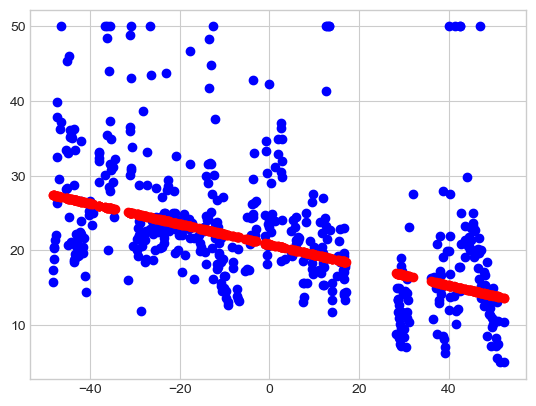

In [35]:
# 그래프에 나타내기 위해 차원 축소
X_comp = TSNE(n_components=1).fit_transform(X)

# 차원 축소한 데이터를 Linear SVR 학습 및 예측 데이터 생성
linear_SVR = SVR(kernel="linear")
linear_SVR.fit(X_comp, y)
y_predict = linear_SVR.predict(X_comp)

# 실제 주택 가격
plt.scatter(X_comp, y, color="b")

# 예측 주택 가격
plt.scatter(X_comp, y_predict, color="r");

#### 당뇨병 데이터

In [36]:
# 당뇨병 데이터 불러오기
X, y = load_diabetes(return_X_y=True) 

In [37]:
# 학습/테스트 데이터 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Pipeline으로 데이터 표준화 및 Linear SVR 학습
pipe = Pipeline([("scaler", StandardScaler()),
                 ("linear_SVR", SVR(kernel="linear"))])
pipe.fit(X_train, y_train)

# 모델 평가
print("Linear SVR 학습 데이터 점수: {}".format(pipe.score(X_train, y_train)))
print("Linear SVR 평가 데이터 점수: {}".format(pipe.score(X_test, y_test)))

Linear SVR 학습 데이터 점수: 0.4924571456889476
Linear SVR 평가 데이터 점수: 0.5570011865236197


- 교차검증 수행

In [38]:
# cross_validate으로 교차검증 수행
cross_validate(estimator=pipe,
               X=X, y=y,
               verbose=True,
               n_jobs=multiprocessing.cpu_count(),
               cv=5)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    1.2s finished


{'fit_time': array([0.00623536, 0.00691795, 0.00523901, 0.00585127, 0.00578594]),
 'score_time': array([0.00118589, 0.00192499, 0.00103092, 0.00135279, 0.0010643 ]),
 'test_score': array([0.43039087, 0.51655019, 0.48275821, 0.4224617 , 0.53077081])}

- GridSearchCV 수행

In [39]:
# Pipeline으로 pipe(객체) 생성
pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", SVR(kernel="linear"))])

# 파라미터 후보군
pararm_grid = {"model__C": [1.0, 0.5 , 0.1, 0.05],
               "model__gamma": ["scale", "auto"],
               "model__epsilon": [1.1, 0.5, 0.1, 0.05]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=pipe,
                  param_grid=pararm_grid,
                  verbose=True,
                  n_jobs=multiprocessing.cpu_count(),
                  cv=5)
gs.fit(X, y)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 파라미터의 점수
print("GridSearchCV best score: {}".format(gs.best_score_))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'model__C': 1.0, 'model__epsilon': 1.1, 'model__gamma': 'scale'}
GridSearchCV best score: 0.4778969345462395


- 시각화

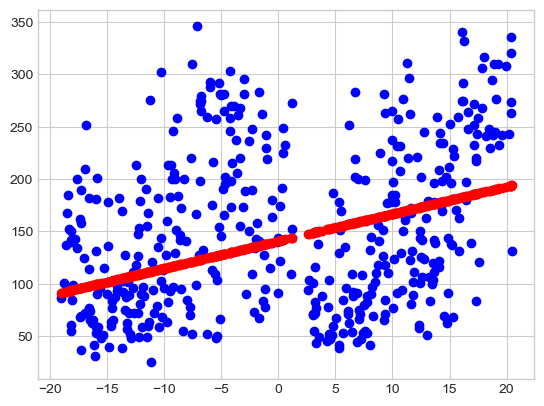

In [40]:
# 그래프에 나타내기 위해 차원 축소
X_comp = TSNE(n_components=1).fit_transform(X)

# 차원 축소한 데이터를 Linear SVR 학습 및 예측 데이터 생성
linear_SVR = SVR(kernel="linear")
linear_SVR.fit(X_comp, y)
y_predict = linear_SVR.predict(X_comp)

# 실제 당뇨 수치
plt.scatter(X_comp, y, color="b")

# 예측 당뇨 수치
plt.scatter(X_comp, y_predict, color="r");

### Kernel SVR

#### 보스턴 주택 가격

In [41]:
# 보스턴 주택 가격 데이터 불러오기
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

boston_df = pd.DataFrame(data)
boston_df["Target"] = target
X, y = data, target

In [42]:
# 학습/테스트 데이터 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Pipeline으로 데이터 표준화 및 RBF SVR 학습
pipe = Pipeline([("scaler", StandardScaler()),
                 ("rbf_SVR", SVR(kernel="rbf"))])
pipe.fit(X_train, y_train)

# 모델 평가
print("RBF SVR 학습 데이터 점수: {}".format(pipe.score(X_train, y_train)))
print("RBF SVR 평가 데이터 점수: {}".format(pipe.score(X_test, y_test)))

RBF SVR 학습 데이터 점수: 0.6804558691341751
RBF SVR 평가 데이터 점수: 0.5895829313193316


- 교차검증 수행

In [45]:
# cross_validate으로 교차검증 수행
cross_validate(estimator=pipe,
               X=X, y=y,
               cv=5,
               verbose=True,
               n_jobs=multiprocessing.cpu_count())

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00739813, 0.00769186, 0.00707293, 0.00708103, 0.00735211]),
 'score_time': array([0.00473881, 0.00454211, 0.00466013, 0.00448298, 0.00451708]),
 'test_score': array([ 0.75781445,  0.50211018,  0.04310107,  0.33851703, -0.75997942])}

- GridSearchCV 수행

In [52]:
# Pipeline으로 pipe(객체) 생성
pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", SVR())])

# 파라미터 후보군
pararm_grid = {"model__kernel": ["rbf", "sigmoid", "poly"],
               "model__C": [1.0, 0.5 , 0.1, 0.05],
               "model__gamma": ["scale", "auto"],
               "model__epsilon": [1.0, 0.5, 0.1, 0.05]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=pipe,
                  param_grid=pararm_grid,
                  verbose=True,
                  cv=5,
                  n_jobs=multiprocessing.cpu_count())
gs.fit(X, y)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 파라미터의 점수
print("GridSearchCV best score: {}".format(gs.best_score_))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'model__C': 0.5, 'model__epsilon': 1.0, 'model__gamma': 'scale', 'model__kernel': 'sigmoid'}
GridSearchCV best score: 0.3922709634398179


- 시각화

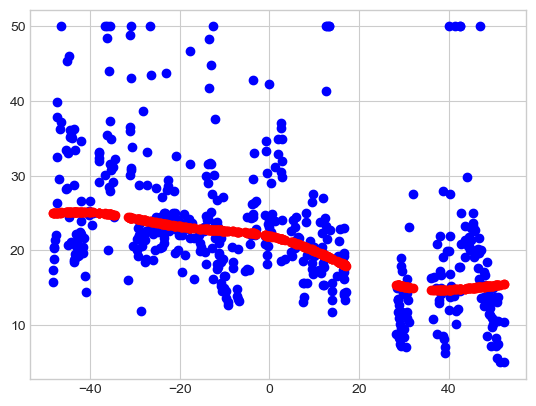

In [53]:
# 그래프에 나타내기 위해 차원 축소
X_comp = TSNE(n_components=1).fit_transform(X)

# 차원 축소한 데이터를 Linear SVR 학습 및 예측 데이터 생성
rbf_SVR = SVR(kernel="rbf")
rbf_SVR.fit(X_comp, y)
y_predict = rbf_SVR.predict(X_comp)

# 실제 주택 가격
plt.scatter(X_comp, y, color="b")

# 예측 주택 가격
plt.scatter(X_comp, y_predict, color="r");

#### 당뇨병 데이터

In [54]:
# 당뇨병 데이터 불러오기
X, y = load_diabetes(return_X_y=True) 

In [55]:
# 학습/테스트 데이터 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Pipeline으로 데이터 표준화 및 Linear SVR 학습
pipe = Pipeline([("scaler", StandardScaler()),
                 ("linear_SVR", SVR(kernel="rbf"))])
pipe.fit(X_train, y_train)

# 모델 평가
print("RBF SVR 학습 데이터 점수: {}".format(pipe.score(X_train, y_train)))
print("RBF SVR 평가 데이터 점수: {}".format(pipe.score(X_test, y_test)))

RBF SVR 학습 데이터 점수: 0.153449915913059
RBF SVR 평가 데이터 점수: 0.18096545981234435


- 교차검증 수행

In [56]:
# cross_validate으로 교차검증 수행
cross_validate(estimator=pipe,
               X=X, y=y,
               verbose=True,
               n_jobs=multiprocessing.cpu_count(),
               cv=5)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00537992, 0.00583291, 0.00563288, 0.00547099, 0.00545311]),
 'score_time': array([0.0038259 , 0.00351095, 0.00383186, 0.00363612, 0.00340986]),
 'test_score': array([0.14580768, 0.12539699, 0.18163843, 0.12222929, 0.15792104])}

- GridSearchCV 수행

In [58]:
# Pipeline으로 pipe(객체) 생성
pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", SVR())])

# 파라미터 후보군
pararm_grid = {"model__kernel": ["rbf", "sigmoid", "poly"],
               "model__C": [1.0, 0.5 , 0.1, 0.05],
               "model__gamma": ["scale", "auto"],
               "model__epsilon": [1.0, 0.5, 0.1, 0.05]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=pipe,
                  param_grid=pararm_grid,
                  verbose=True,
                  n_jobs=multiprocessing.cpu_count(),
                  cv=5)
gs.fit(X, y)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 파라미터의 점수
print("GridSearchCV best score: {}".format(gs.best_score_))

# 최적의 estimator 평가
model = gs.best_estimator_
model.fit(X_train, y_train)
print("최적의 estimator 학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("최적의 estimator 평가 데이터 점수: {}".format(model.score(X_test, y_test)))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'model__C': 1.0, 'model__epsilon': 1.0, 'model__gamma': 'scale', 'model__kernel': 'sigmoid'}
GridSearchCV best score: 0.3500114055590588
최적의 estimator 학습 데이터 점수: 0.37265056205893954
최적의 estimator 평가 데이터 점수: 0.3905582128144086


- 시각화

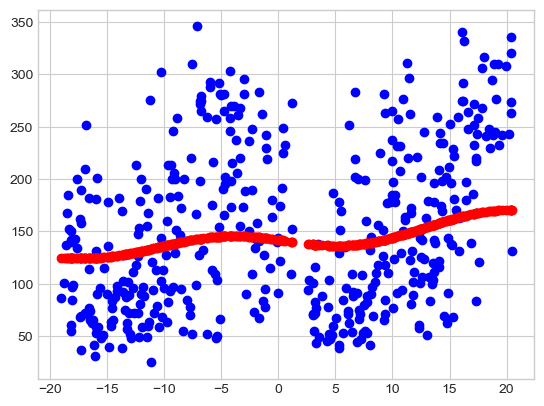

In [60]:
# 그래프에 나타내기 위해 차원 축소
X_comp = TSNE(n_components=1).fit_transform(X)

# 차원 축소한 데이터를 Linear SVR 학습 및 예측 데이터 생성
rbf_SVR = SVR(kernel="rbf")
rbf_SVR.fit(X_comp, y)
y_predict = rbf_SVR.predict(X_comp)

# 실제 당뇨 수치
plt.scatter(X_comp, y, color="b")

# 예측 당뇨 수치
plt.scatter(X_comp, y_predict, color="r");

## SVM을 사용한 분류 모델(SVC)
- ![](2023-04-18-15-27-27.png)

### Linear SVC

#### 유방암 데이터

In [62]:
# 유방암 데이터 불러오기
X, y = load_breast_cancer(return_X_y=True)

In [63]:
# 학습/테스트 데이터 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Pipeline으로 데이터 표준화 및 Linear SVC 학습
pipe = Pipeline([("scaler", StandardScaler()),
                 ("linear_SVC", SVC(kernel="linear"))])
pipe.fit(X_train, y_train)

# 모델 평가
print("Linear SVC 학습 데이터 점수: {}".format(pipe.score(X_train, y_train)))
print("Linear SVC 평가 데이터 점수: {}".format(pipe.score(X_test, y_test)))

Linear SVC 학습 데이터 점수: 0.9868131868131869
Linear SVC 평가 데이터 점수: 0.9912280701754386


- 교차검증 수행

In [64]:
# cross_validate으로 교차검증 수행
cross_validate(estimator=pipe,
               X=X, y=y,
               verbose=True,
               n_jobs=multiprocessing.cpu_count(),
               cv=5)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    1.2s finished


{'fit_time': array([0.00373483, 0.00313187, 0.00313997, 0.00295782, 0.00303102]),
 'score_time': array([0.00062513, 0.00062609, 0.00057411, 0.00057483, 0.00056195]),
 'test_score': array([0.96491228, 0.98245614, 0.96491228, 0.96491228, 0.98230088])}

- GridSearchCV 수행

In [67]:
# Pipeline으로 pipe(객체) 생성
pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", SVC(kernel="linear"))])

# 파라미터 후보군
pararm_grid = {"model__C": [1.0, 0.5, 0.1, 0.01],
               "model__gamma": ["scale", "auto"]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=pipe,
                  param_grid=pararm_grid,
                  n_jobs=multiprocessing.cpu_count(),
                  verbose=True,
                  cv=5)
gs.fit(X, y)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 파라미터의 점수
print("GridSearchCV best score: {}".format(gs.best_score_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'model__C': 0.1, 'model__gamma': 'scale'}
GridSearchCV best score: 0.9736531594472908


- 시각화

In [68]:
# 격자 그리드 형태 데이터들을 생성할 함수
def get_meshgrid(x, y, h=0.02):
    xx, yy = np.meshgrid(np.arange(x.min()-1, x.max()+1, h), np.arange(y.min()-1, y.max()+1, h))
    return xx, yy

# 그래프에 각 클래스에 대한 영역을 구분해줄 함수
def get_contourf(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return plt.contourf(xx, yy, Z, **params)

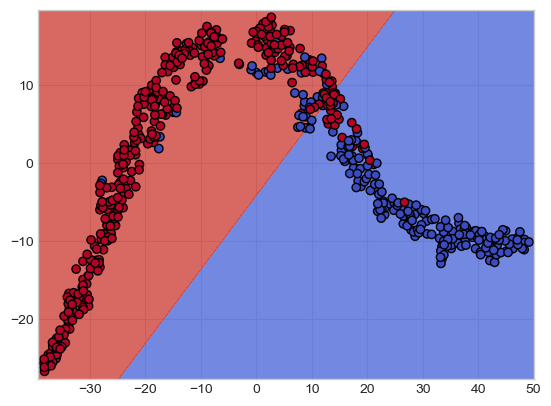

In [71]:
# 그래프에 나타내기 위해 차원 축소
X_comp = TSNE(n_components=2).fit_transform(X)

# 차원 축소한 데이터를 Linear SVC 학습
linear_SVC = SVC(kernel="linear")
linear_SVC.fit(X_comp, y)

# 각 클래스의 영역을 구분할 데이터들을 생성
xx, yy = get_meshgrid(X_comp[:, 0], X_comp[:, 1])

# 영역을 구분할 데이터들을 분류 및 영역 구분
get_contourf(linear_SVC, xx, yy, alpha=0.8, cmap=plt.cm.coolwarm)

# 분류된 데이터들을 산점도로 시각화
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors="k");

#### 붓꽃 데이터

In [72]:
# 붓꽃 데이터 불러오기
X, y = load_iris(return_X_y=True)

In [73]:
# 학습/테스트 데이터 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Pipeline으로 데이터 표준화 및 Linear SVC 학습
pipe = Pipeline([("scaler", StandardScaler()),
                 ("linear_SVC", SVC(kernel="linear"))])
pipe.fit(X_train, y_train)

# 모델 평가
print("Linear SVC 학습 데이터 점수: {}".format(pipe.score(X_train, y_train)))
print("Linear SVC 평가 데이터 점수: {}".format(pipe.score(X_test, y_test)))

Linear SVC 학습 데이터 점수: 0.9833333333333333
Linear SVC 평가 데이터 점수: 0.9333333333333333


- 교차검증 수행

In [74]:
# cross_validate으로 교차검증 수행
cross_validate(estimator=pipe,
               X=X, y=y,
               verbose=True,
               n_jobs=multiprocessing.cpu_count(),
               cv=5)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    1.0s finished


{'fit_time': array([0.00162506, 0.00167608, 0.00164199, 0.00158191, 0.00166202]),
 'score_time': array([0.00041389, 0.00041699, 0.00041103, 0.00042915, 0.00042486]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.93333333, 1.        ])}

- GridSearchCV 수행

In [83]:
# Pipeline으로 pipe(객체) 생성
pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", SVC(kernel="linear"))])

# 파라미터 후보군
pararm_grid = {"model__C": [1.0, 0.5, 0.1, 0.01],
               "model__gamma": ["scale", "auto"]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=pipe,
                  param_grid=pararm_grid,
                  n_jobs=multiprocessing.cpu_count(),
                  verbose=True,
                  cv=5)
gs.fit(X, y)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 파라미터의 점수
print("GridSearchCV best score: {}".format(gs.best_score_))

# 최적의 estimator 평가
model = gs.best_estimator_
model.fit(X_train, y_train)
print("최적의 estimator 학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("최적의 estimator 평가 데이터 점수: {}".format(model.score(X_test, y_test)))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'model__C': 0.5, 'model__gamma': 'scale'}
GridSearchCV best score: 0.9800000000000001
최적의 estimator 학습 데이터 점수: 0.9833333333333333
최적의 estimator 평가 데이터 점수: 0.9333333333333333


- 시각화

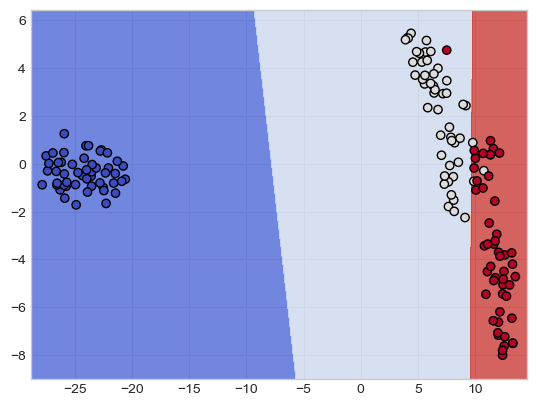

In [84]:
# 그래프에 나타내기 위해 차원 축소
X_comp = TSNE(n_components=2).fit_transform(X)

# 차원 축소한 데이터를 Linear SVC 학습
linear_SVC = SVC(kernel="linear")
linear_SVC.fit(X_comp, y)

# 각 클래스의 영역을 구분할 데이터들을 생성
xx, yy = get_meshgrid(X_comp[:, 0], X_comp[:, 1])

# 영역을 구분할 데이터들을 분류 및 영역 구분
get_contourf(linear_SVC, xx, yy, alpha=0.8, cmap=plt.cm.coolwarm)

# 분류된 데이터들을 산점도로 시각화
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors="k");

### Kernel SVC

#### 유방암 데이터

In [85]:
# 유방암 데이터 불러오기
X, y = load_breast_cancer(return_X_y=True)

In [86]:
# 학습/테스트 데이터 셋 불러오기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Pipeline으로 데이터 표준화 및 RBF SVC 학습
pipe = Pipeline([("scaler", StandardScaler()),
                 ("rbf_SVC", SVC(kernel="rbf"))])
pipe.fit(X_train, y_train)

# 모델 평가
print("RBF SVC 학습 데이터 점수: {}".format(pipe.score(X_train, y_train)))
print("RBF SVC 평가 데이터 점수: {}".format(pipe.score(X_test, y_test)))

RBF SVC 학습 데이터 점수: 0.9868131868131869
RBF SVC 평가 데이터 점수: 0.9824561403508771


- 교차검증 수행

In [87]:
# cross_validate으로 교차검증 수행
cross_validate(estimator=pipe,
               X=X, y=y,
               verbose=True,
               n_jobs=multiprocessing.cpu_count(),
               cv=5)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.9s finished


{'fit_time': array([0.00398612, 0.00402617, 0.0042541 , 0.00413489, 0.00431418]),
 'score_time': array([0.0017581 , 0.00181699, 0.00183916, 0.00173593, 0.00184584]),
 'test_score': array([0.97368421, 0.95614035, 1.        , 0.96491228, 0.97345133])}

In [107]:
# KFold 교차검증
cv = KFold(5,
           shuffle=True,
           random_state=123)

auc_score_list = []
for i, (train, test) in enumerate(cv.split(X, y)):
    # 5개로 분할된 fold 중 4개를 학습 데이터셋, 1개를 테스트 데이터 셋으로 지정. 매 반복시마다, 테스트 데이터셋은 변경됨.
    splited_X_train, splited_X_test = X[train], X[test]
    splited_y_train, splited_y_test = y[train], y[test]
    
    # 지정한 학습 데이터셋으로 RBF SVC 학습 및 예측 확률 데이터 생성
    model = SVC(kernel="rbf",
                probability=True)
    model.fit(splited_X_train, splited_y_train)
    y_predict_probability = model.predict_proba(splited_X_test)[:, 1]

    # 모델 평가(모델 점수, AUC Score)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(splited_y_test, y_predict_probability)
    roc_score = roc_auc_score(splited_y_test, y_predict_probability)
    auc_score_list.append(roc_score)
    print("{}번째 KFold 학습 데이터 점수: {}".format(i + 1, model.score(splited_X_train, splited_y_train)))
    print("{}번째 KFold 평가 데이터 점수: {}".format(i + 1, model.score(splited_X_test, splited_y_test)))
    print("{}번째 AUC score: {}".format(i + 1, roc_score))
    print("----------------------------------------------------")

1번째 KFold 학습 데이터 점수: 0.9032967032967033
1번째 KFold 평가 데이터 점수: 0.9298245614035088
1번째 AUC score: 0.9859672569328433
----------------------------------------------------
2번째 KFold 학습 데이터 점수: 0.9208791208791208
2번째 KFold 평가 데이터 점수: 0.9210526315789473
2번째 AUC score: 0.9618926643378851
----------------------------------------------------
3번째 KFold 학습 데이터 점수: 0.9164835164835164
3번째 KFold 평가 데이터 점수: 0.9298245614035088
3번째 AUC score: 0.9803439803439804
----------------------------------------------------
4번째 KFold 학습 데이터 점수: 0.9142857142857143
4번째 KFold 평가 데이터 점수: 0.9298245614035088
4번째 AUC score: 0.9851190476190476
----------------------------------------------------
5번째 KFold 학습 데이터 점수: 0.9298245614035088
5번째 KFold 평가 데이터 점수: 0.8761061946902655
5번째 AUC score: 0.9607843137254902
----------------------------------------------------


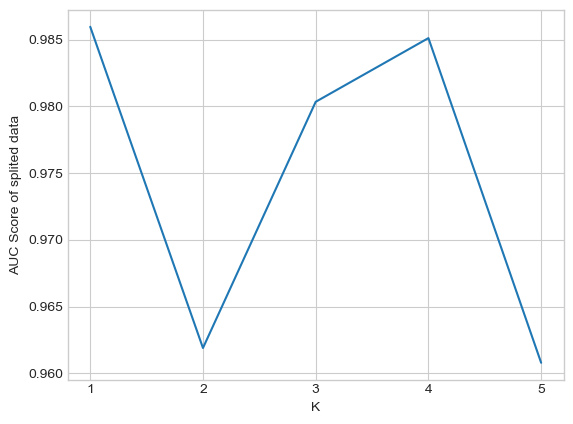

In [122]:
# AUC Score를 시각화
plt.plot(auc_score_list)
plt.xlabel("K")
plt.ylabel("AUC Score of splited data")
plt.xticks(np.arange(5), np.arange(1, 6, 1));

- GridSearchCV 수행

In [143]:
# Pipeline으로 pipe(객체) 생성
pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", SVC())])

# 파라미터 후보군
pararm_grid = {"model__kernel": ["rbf", "sigmoid", "poly"],
               "model__C": [1.0, 3.0, 5.0],
               "model__gamma": ["scale", "auto"]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=pipe,
                  param_grid=pararm_grid,
                  verbose=True,
                  n_jobs=multiprocessing.cpu_count(),
                  cv=5)
gs.fit(X, y)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 파라미터의 점수
print("GridSearchCV best score: {}".format(gs.best_score_))

# 최적의 estimator 평가
model = gs.best_estimator_
model.fit(X_train, y_train)
print("최적의 estimator 학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("최적의 estimator 평가 데이터 점수: {}".format(model.score(X_test, y_test)))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'model__C': 3.0, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
GridSearchCV best score: 0.9789318428815401
최적의 estimator 학습 데이터 점수: 0.989010989010989
최적의 estimator 평가 데이터 점수: 0.9912280701754386


- 시각화

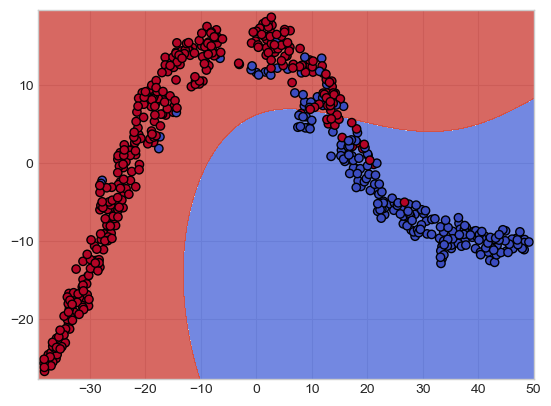

In [145]:
# 그래프에 나타내기 위해 차원 축소
X_comp = TSNE(n_components=2).fit_transform(X)

# 차원 축소한 데이터를 rbf SVC 학습
rbf_SVC = SVC(kernel="rbf")
rbf_SVC.fit(X_comp, y)

# 각 클래스의 영역을 구분할 데이터들을 생성
xx, yy = get_meshgrid(X_comp[:, 0], X_comp[:, 1])

# 영역을 구분할 데이터들을 분류 및 영역 구분
get_contourf(rbf_SVC, xx, yy, alpha=0.8, cmap=plt.cm.coolwarm)

# 분류된 데이터들을 산점도로 시각화
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors="k");

#### 붓꽃 데이터

In [146]:
# 붓꽃 데이터 불러오기
X, y = load_iris(return_X_y=True)

In [147]:
# 학습/테스트 데이터 셋 불러오기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Pipeline으로 데이터 표준화 및 RBF SVC 학습
pipe = Pipeline([("scaler", StandardScaler()),
                 ("rbf_SVC", SVC(kernel="rbf"))])
pipe.fit(X_train, y_train)

# 모델 평가
print("RBF SVC 학습 데이터 점수: {}".format(pipe.score(X_train, y_train)))
print("RBF SVC 평가 데이터 점수: {}".format(pipe.score(X_test, y_test)))

RBF SVC 학습 데이터 점수: 0.9833333333333333
RBF SVC 평가 데이터 점수: 0.9333333333333333


- 교차검증 수행

In [148]:
# cross_validate으로 교차검증 수행
cross_validate(estimator=pipe,
               X=X, y=y,
               verbose=True,
               n_jobs=multiprocessing.cpu_count(),
               cv=5)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    1.0s finished


{'fit_time': array([0.00163579, 0.0017271 , 0.0017271 , 0.00166202, 0.00171709]),
 'score_time': array([0.00054693, 0.00058484, 0.0005722 , 0.00054502, 0.00057387]),
 'test_score': array([0.96666667, 0.96666667, 0.96666667, 0.93333333, 1.        ])}

In [152]:
# KFold 교차검증
cv = KFold(5,
           shuffle=True,
           random_state=123)

auc_score_list = []
for i, (train, test) in enumerate(cv.split(X, y)):
    # 5개로 분할된 fold 중 4개를 학습 데이터셋, 1개를 테스트 데이터 셋으로 지정. 매 반복시마다, 테스트 데이터셋은 변경됨.
    splited_X_train, splited_X_test = X[train], X[test]
    splited_y_train, splited_y_test = y[train], y[test]
    
    # 지정한 학습 데이터셋으로 RBF SVC 학습 및 예측 확률 데이터 생성
    model = SVC(kernel="rbf",
                probability=True)
    model.fit(splited_X_train, splited_y_train)
    y_predict_probability = model.predict_proba(splited_X_test)[:, 1]

    # 모델 평가
    print("{}번째 KFold 학습 데이터 점수: {}".format(i + 1, model.score(splited_X_train, splited_y_train)))
    print("{}번째 KFold 평가 데이터 점수: {}".format(i + 1, model.score(splited_X_test, splited_y_test)))
    print("----------------------------------------------------")

1번째 KFold 학습 데이터 점수: 0.975
1번째 KFold 평가 데이터 점수: 0.9666666666666667
----------------------------------------------------
2번째 KFold 학습 데이터 점수: 0.9416666666666667
2번째 KFold 평가 데이터 점수: 0.9666666666666667
----------------------------------------------------
3번째 KFold 학습 데이터 점수: 0.95
3번째 KFold 평가 데이터 점수: 1.0
----------------------------------------------------
4번째 KFold 학습 데이터 점수: 0.975
4번째 KFold 평가 데이터 점수: 0.9666666666666667
----------------------------------------------------
5번째 KFold 학습 데이터 점수: 0.9916666666666667
5번째 KFold 평가 데이터 점수: 0.9333333333333333
----------------------------------------------------


- GridSearchCV 수행

In [161]:
# Pipeline으로 pipe(객체) 생성
pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", SVC())])

# 파라미터 후보군
pararm_grid = {"model__kernel": ["rbf", "sigmoid", "poly"],
               "model__C": [1.0, 3.0, 5.0],
               "model__gamma": ["scale", "auto"]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=pipe,
                  param_grid=pararm_grid,
                  verbose=True,
                  n_jobs=multiprocessing.cpu_count(),
                  cv=5)
gs.fit(X, y)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 파라미터의 점수
print("GridSearchCV best score: {}".format(gs.best_score_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'model__C': 5.0, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
GridSearchCV best score: 0.9733333333333334


- 시각화

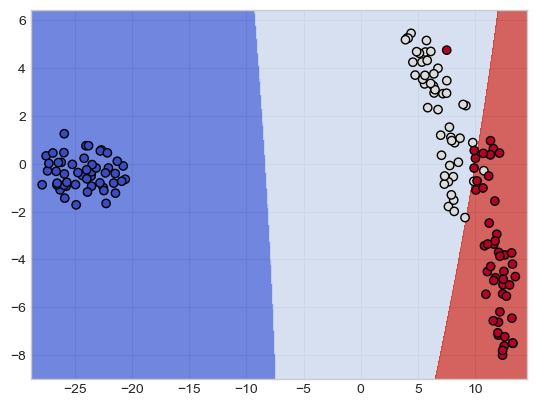

In [162]:
# 그래프에 나타내기 위해 차원 축소
X_comp = TSNE(n_components=2).fit_transform(X)

# 차원 축소한 데이터를 rbf SVC 학습
rbf_SVC = SVC(kernel="rbf")
rbf_SVC.fit(X_comp, y)

# 각 클래스의 영역을 구분할 데이터들을 생성
xx, yy = get_meshgrid(X_comp[:, 0], X_comp[:, 1])

# 영역을 구분할 데이터들을 분류 및 영역 구분
get_contourf(rbf_SVC, xx, yy, alpha=0.8, cmap=plt.cm.coolwarm)

# 분류된 데이터들을 산점도로 시각화
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors="k");